# Adam Thomson - PHY 573 - Week 7

## Grover's Algorithm

Following the qiskit tutorial https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb
- Explain Introduction steps 1, 2, 3
- Copy and run 2 qubit implementation
- Explain the purpose of the diffuser

Grover's Algorithm is a quantum solution to the unordered search problem. Let's examine how a quantum computer can provide a quadratic improvement over classical computing when searching an unstructured database.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from fractions import Fraction
from math import gcd
from numpy.random import randint
from IPython.display import Math, HTML
from qiskit import QuantumCircuit as QCir, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Initialize local simulator
sampler = AerSimulator()

# Declare shortcut function
def dm(x):
    return display(Math(x))

In [6]:
# Explain the problem setup
dm(r"\text{We start with an array of } N \text{ items, for simplicity we'll assume } N=2^n")
dm(r"\text{In this array, there is a single item that satisfies our desired condition, at index } \omega")
dm(r"\text{The tutorial provides an illustration where all items in a list are grey except one is purple, our } \omega")
dm(r"\text{Classically, this search is } O(N), \text{ as it picks random entries to check; in the worst case it checks all entries.}")
dm(r"\text{However, a quantum computer can leverage amplitude amplification to find } \omega \text{ in } \sqrt{N} \text{ steps.}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Algorithm Overview

Grover's algorithm consists of 3 main steps: state preparation, the oracle function, and the diffusion operator. State preparation only happens once, but application of the oracle function and diffusion operator may need to be repeated before measurement for optimal results.

- State preparation: By applying a Hadamard gate to all input qubits individually, we create a search space that includes all possible answers in a uniform superposition
- Grover's Oracle: This step takes all qubits as input and is responsible for "marking" the correct entry by flipping the phase of its amplitude
- Diffusion Operator: This step also takes in all qubits as input, and will result in growing the marked state's amplitude while dampening the amplitude of unmarked states
- Measurement: After you have repeated the oracle and diffusion operator enough times that you've calculated the amplitude of the desired state to be maximal, you take a measurement

The tutorial has 2 different ways of visualizing the circuit's state at each step that I will be referencing:
- A graph of the amplitude of each possible state in the search space
- A space defined by the vertical axis as |w>, our desired state, and the horizontal axis, |s'>, is a modified uniform superposition state such that the marked entry's amplitude is 0 and the leading coefficient is scaled accordingly

#### Step 1 - Constructing the Search Space

In [35]:
# Explain the setup
dm(r"\text{To prepare for the algoritm, we need to initialize the state with a uniform superposition: } \
    \ket{s} = \frac1{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}")
dm(r"\text{Starting from } \ket{0}^{\otimes n} \text{, this is easily achieved by applying a Hadamard gate to all qubits.}")
dm(r"\ket{\psi_0} = \ket{s} = (H^{\otimes n}) \ket0^{\otimes n}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

At this point, every state is just as likely to be measured as any other state; this is equivalent to the classical computing approach. Since no guess is any better than any other, we could repeat this and expect to find the right answer in O(N) steps, matching a classical computer.

The visualizations match our expectations, the amplitude of all states are equal as shown, and |s> is not quite horizontal since there is some probability of getting our desired w if we measured immediately. The exact difference between |s> and |s'> will become important in a moment, so let's zoom in.

In [49]:
# Examine |s> and |s'>
dm(r"\text{Above, we defined } \ket{s'} \text{ based on the uniform superposition } \ket{s}")
dm(r"""\ket{s'} := \frac1{\sqrt{N-1}} \sum_{x=0}^{N-1}
\begin{cases}
   \ket{x} &\text{if } x \neq \omega \\
   0 &\text{if } x = \omega
\end{cases}
""")
dm(r"\text{Note that the angle between } \ket{s} \text{ and } \ket{s'} \text{ in our radial space, θ, depends on N}")
dm(r"\text{In fact, } \theta = \braket{s'|\omega} = \arcsin( \frac1{\sqrt{N}} )")
dm(r"\text{This means we can express the uniform superposition state in terms of the axes of the visualization:}")
dm(r"\ket{s} = \sin \theta \ket{\omega} + \cos \theta \ket{s'}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Step 2 - Applying the Oracle Function

Now that we have a uniform superposition, we apply the provided oracle function U_f. Definitionally, the algorithm does not concern itself with how the oracle function works, but the result is that the desired result will have its phase flipped to be negative.

The graphs visualize what this does to the state with different effects but can be understood as representing the same action. For the amplitude bar graph, we see that the value for W has the same magnitude but is negative. You can think of this as mirroring the marked state across the horizontal axis of 0.

The radial graph similarly shows that the state vector has been "mirrored" across the horizontal axis, |s'>. You can also think of this action as rotating the state by -2θ in this space.

Note that the amplitude bar graph also uses a dotted line to show that the new average value for all amplitudes is now less than it was in the uniform superposition, 1/√N

In [38]:
# Apply oracle function
dm(r"\text{From the uniform superposition, we next apply the provided oracle function } U_f")
dm(r"\ket{\psi_{0'}} = U_f \ket{\psi_0}")
dm(r"""\ket{\psi_{0'}} = \frac1{\sqrt{N}} \sum_{x=0}^{N-1}
\begin{cases}
   \ket{x} &\text{if } x \neq \omega \\
   -\ket{x} &\text{if } x = \omega
\end{cases}""")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Step 3 - Applying the Diffusion Operator

The Diffusion Operator, U_s, is described as "reflection about the state |s>". This transformation can be expressed as

In [25]:
# Define diffusion operator
dm(r"U_s = 2\ket{s} \bra{s} - 1")

<IPython.core.display.Math object>

The graphs visualize this effect on the state in the following ways. The bar graph shows that the amplitude of the marked state has returned to being positive, and is now of greater magnitude than all of the other amplitudes. Due to the lowered "average" discussed above, the resulting amplitude for all non-marked values has dropped by twice that amount, with the marked value having "absorbed" them into it's own magnitude, now higher than when in the uniform state.

In the radial visualization, we see that the diffusion operator acts as mirroring across the starting uniform superposition vector. This can also be thought of as rotating the state vector by 4θ in this space. This gives a total overall rotation of 2θ from our starting |s>.

In [40]:
# Describe the state after applying the diffusion operator
dm(r"\ket{\psi_1} = U_s \ket{\psi_{0'}} = U_s U_f \ket {s}")

<IPython.core.display.Math object>

#### Repetition

If we were to take a measurement now, we are more likely to measure the desired value than any other value, but there is still a significant probability that we will not measure the correct value. By repeating our application of U_f and U_s, we can further increase the probability of measuring w. However, note that after a certain point we will start to instead reduce the probability of measuring w! We can see this in the radial visualization, if we continue to rotate by 2θ past |w>, we will eventually return to |-s'>.

In [42]:
# Define iterating state
dm(r"\text{In general, let's define } \ket{\psi_t} := (U_s U_f)^t \ket{s}")

<IPython.core.display.Math object>

Clearly, the optimal number of repetitions depends on θ. So far we have only looked at the case when there is a single match in the search space, but the tutorial gives the formula for when there are multiple:

In [45]:
# Equation for optimal number of iterations
dm(r"t = \lfloor \frac{\pi}4 \sqrt{\frac{N}{m}} \rfloor")
dm(r"\text{Where } N \text{ is the size of the search space, and } m \text{ is the number of matches that exist.}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

For our example case of m=1, we see that our optimal t is ~√N, a large improvement on the classical average N/2!

## Example Implementation

#### Setup

We'll take a closer look at the implementation for when N=4, m=1. In this case, we will show that only a single iteration of the oracle and diffusion operator is required to reach |w>.

In [58]:
# Describe the N=4 state
dm(r"\text{Using previous equation, we find that for } N=4:")
dm(r"\theta = \arcsin{\frac12} = \frac{\pi}6")
dm(r"\ket{\psi_t} = (U_s U_\omega)^t \ket{s} = \sin \theta_t \ket\omega + \cos \theta_t \ket{s'}")
dm(r"\text{Where } \theta_t := (2t + 1)\theta")
dm(r"\text{In order to reach } \ket\omega \text{ we need } \theta_t = \frac\pi2")
dm(r"\text{Using θ from above, we find } \frac\pi2 = (2t + 1)\frac\pi6 \rarr t=1")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Initialization

We start by applying a Hadamard gate to both qubits, creating the uniform superposition

In [64]:
# Create a uniform superposition
dm(r"\ket{s} = (H \otimes H)(\ket0 \otimes \ket0) = \frac12(\ket{00} + \ket{01} + \ket{10} + \ket{11})")

<IPython.core.display.Math object>

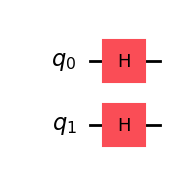

In [75]:
# Draw initial circuit
qc_init = QCir(2)
qc_init.h([0,1])
qc_init.draw(output="mpl")

#### Oracle Function

To continue further, we need to construct the oracle function we will be using. For the sake of the example, we know that |w> = |11>. This means, we need to construct a function such that

In [61]:
# Define our oracle operator
dm(r"U_\omega \ket{s} = \frac12 (\ket{00} + \ket{01} + \ket{10} - \ket{11})")
dm(r"""U_\omega = \begin{bmatrix}
   1 & 0 & 0 & 0 \\
   0 & 1 & 0 & 0 \\
   0 & 0 & 1 & 0 \\
   0 & 0 & 0 & -1
\end{bmatrix}""")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This is the same matrix to represent a controlled-Z gate, thus our oracle function can be implemented with a CZ gate!

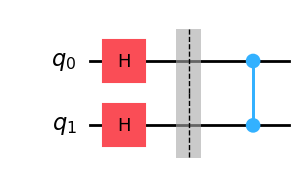

In [81]:
# Draw circuit with oracle
qc_oracle = QCir(2)
qc_oracle.h([0,1])
qc_oracle.barrier()
qc_oracle.cz(0,1)
qc_oracle.draw(output="mpl")

#### Diffusion Operator

Next, we'll need a way of implementing the Diffusion Operator. Since this is a reflection about |s>, we want to add a negative phase to every state orthogonal to |s>.

However, instead of trying to find U_s, we can instead find U_0 and transform |s> into |0>. Let's look at this transformation in detail.

In [71]:
# Describe the steps to produce orthogonal state
dm(r"\text{We would like to find } U_s = 2\ket{s}\bra{s} - 1")
dm(r"\text{To make this easier, we use the defintion of } \ket{s} \text{ to state }")
dm(r"H^{\otimes n} \ket{s} = \ket0")
dm(r"\text{Consider this circuit } U_0 \text{ that will phase flip all states orthogonal to } \ket0_n")
dm(r"U_0 \ket{s} = U_0 \frac12 (\ket{00} + \ket{01} + \ket{10} + \ket{11})")
dm(r"\qquad = \frac12 (\ket{00} - \ket{01} - \ket{10} - \ket{11})")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can achieve this by using this following circuit provided by the tutorial.

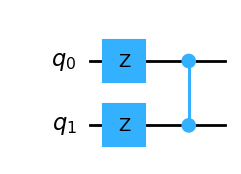

In [73]:
# Draw circuit for U_0
qc_u0 = QCir(2)
qc_u0.z([0,1])
qc_u0.cz(0,1)
qc_u0.draw(output="mpl")

We then bring these together to get the following circuit for the diffusion operator

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

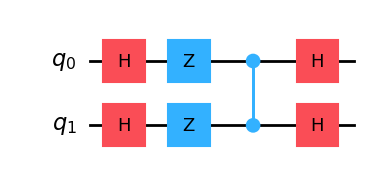

In [83]:
# Construct the diffusion operator
dm(r"\text{By applying a Hadamard gate to each qubit again, we finish constructing } U_s")
dm(r"H^{\otimes n} \ket{s} = \ket0")
dm(r"U_s = H^{\otimes n} U_0 H^{\otimes n}")
qc_diff = QCir(2)
qc_diff.h([0,1])
qc_diff.z([0,1])
qc_diff.cz(0,1)
qc_diff.h([0,1])
qc_diff.draw(output="mpl")


Since we already showed early why the optimal t=1, we can now construct the full circuit to implement Grover's algorithm on a 2-qubit system.

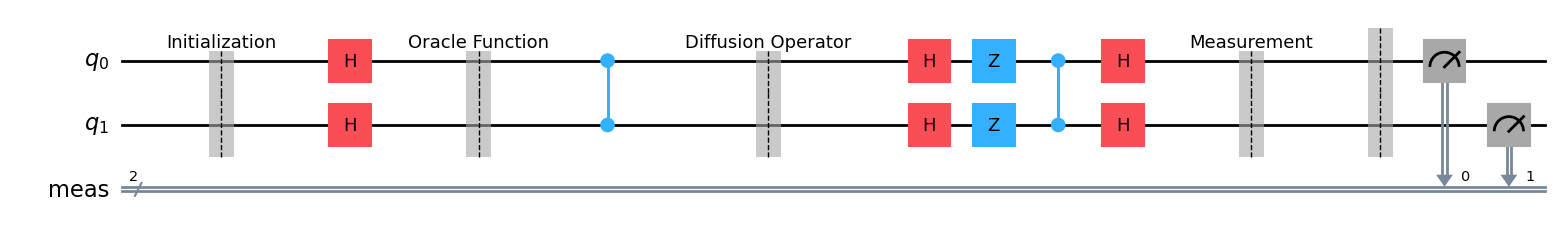

In [87]:
# Build 2-qubit grover circuit
grover_circuit = QCir(2)
grover_circuit.barrier(label="Initialization")
grover_circuit.h([0,1])
grover_circuit.barrier(label="Oracle Function")
grover_circuit.cz(0,1)
grover_circuit.barrier(label="Diffusion Operator")
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.barrier(label="Measurement")
grover_circuit.measure_all()
grover_circuit.draw(output="mpl")

### Experimentation

Now that we've built the circuit for Grover's algorithm, let's test it out with a local simulator and real hardware to interpret the results.

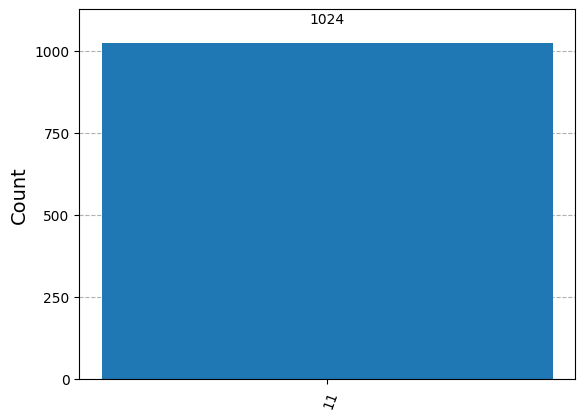

In [88]:
# Run on local simulator
sim_results = sampler.run(grover_circuit).result()
plot_histogram(sim_results.get_counts())

As expected, we get |11> back 100% of the time after a single application of the oracle function and diffusion operator! Now let's check the results on a real device.

In [94]:
# Real hardware experiment setup
# Additional imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

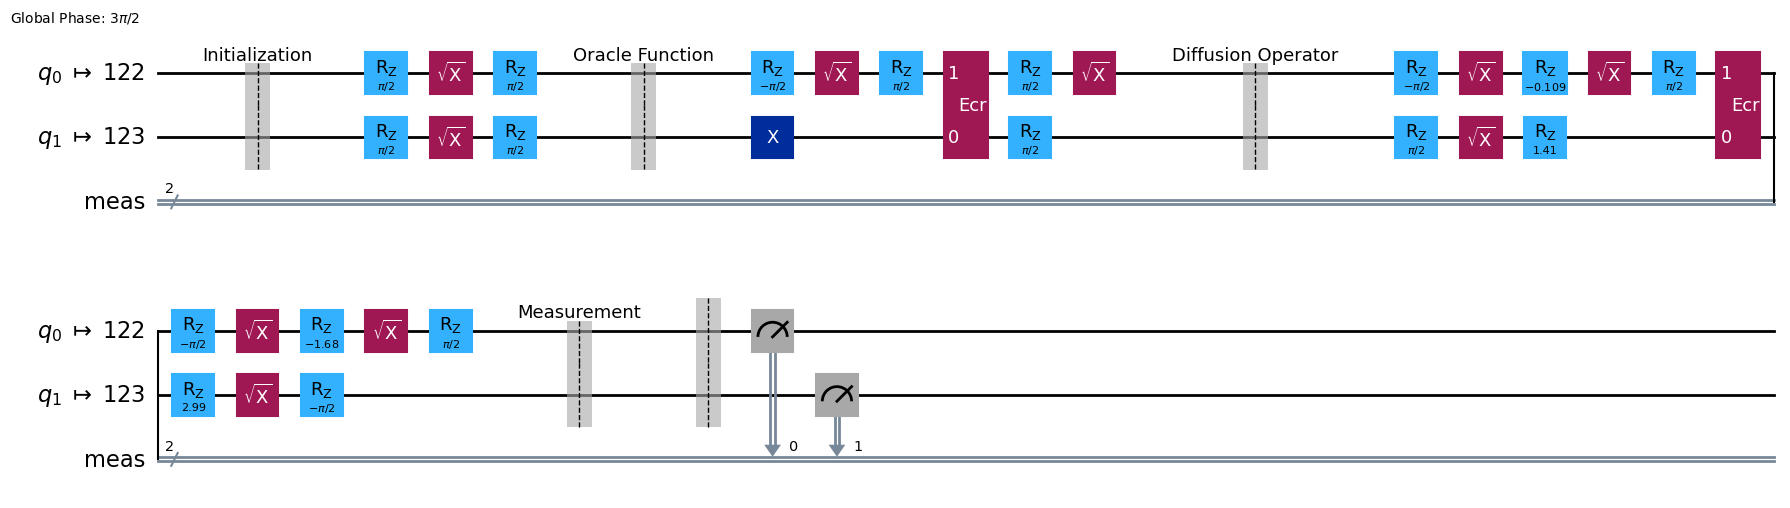

In [95]:
# Transpile the circuit for operating on real quantum hardward
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(grover_circuit)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [97]:
# Run the circuit and wait for the results
sampler2 = SamplerV2(mode=backend)
sampler2.options.default_shots = 1_000
result = sampler2.run([circuit_isa]).result()[0]

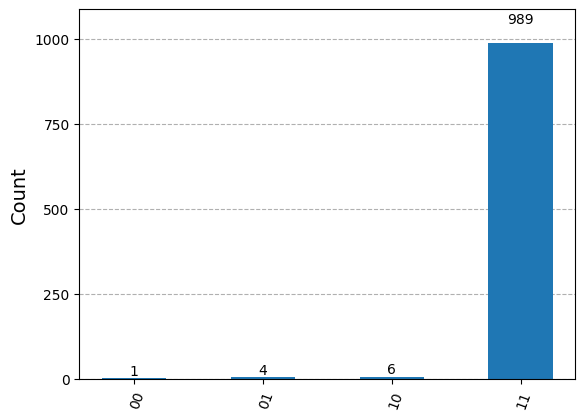

In [99]:
# Plot the results
test_counts = result.data.meas.get_counts()
plot_histogram(test_counts)

Indeed, we see that the real hardware has an overwhelming probability of returning the correct result |11>, but there is a small percentage chance of measuring the other values due to errors.

Grover's algorithm is a demonstration of a technique called amplitude amplification that has many uses across quantum computing. In particular, the Diffusion operator is incredibly powerful in it's ability to both increase the amplitude of desired states while decreasing the amplitude of undesired states!